In [1]:
import pandas as pd
import matplotlib.pyplot as plt

<font size="4"><b>Understanding our data.</b></font>

The datasets under analysis have been obtained from data.cms.gov(https://data.cms.gov/provider-data/dataset/nrth-mfg3). 

The datasets span the years of 2019-2022, and contain uniform column titles across the 4 years, these colums include: 

1) 'Facility Name': the name of each hospital included in the dataset
   
2) 'Facility ID': the id number of each hospital included in the dataset

3) 'State': the state each hospital is located in
   
4) 'Period': the period column contains three cateogries of patient care periods: '1 to 3 days prior to Index Hospital Admission',
    'During Index Hospital Admission', 1 through 30 days After Discharge from Index Hospital Admission'.
    
5) 'Claim Type: patient care claim types include: 'Home Health Agency', 'Hospice', 'Inpatient', 'Outpatient', 'Skilled Nursing Facility', 
  'Durable Medical Equipment', 'Carrier', 'Total (this is the aggregation of hospital spending on each claim type)

6) 'Average Spndg per EP Hospital': each respective facility's $ amount spent on each claim type for each period.

8) 'Start Date' and 'End Date': the start date for each claim, and end date for each claim.

Notes:

The datsets contain other columns referring to 'Average Spndg per EP State' and '....National', but these have been ommited for the purposes of this analysis. 

The 2019, 2021, 2022 datasets all begin on the first of the month (1/1), while claims data for 2020 begins July 1st. This is due to CMS refraining to publish CMS data to public record during the NHE (National Health Emergency). Record of this ommission can be found here: https://www.cms.gov/files/document/questionsandanswersclaims-basedmeasuresfeb2022.pdf



<font size="4"><b>Defining variables </b></font>
-will add to this by EOD - ZFS

<font size="4"><b>IMPORTING AND FILTERING DATA FROM CSVs:</b></font>

WITH TOTAL ROW 

In [2]:
def get_yearly_data_with_total(year):
    medicare = pd.read_csv(f"input/Medicare_{year}.csv",encoding='utf-8')
    with_total= medicare[medicare['Claim Type']=='Total'][["Facility Name", "Facility ID", "State", "Period", 
                                                                        "Claim Type", "Avg Spndg Per EP Hospital"]]
    with_total['year'] = year
    return with_total

WITHOUT TOTAL ROW 

In [3]:
def get_yearly_data_no_total(year):
    medicare = pd.read_csv(f"input/Medicare_{year}.csv",encoding='utf-8')
    #2019 dataset without 'Total'
    no_total= medicare[medicare['Claim Type']!='Total'][["Facility Name", "Facility ID", "State", "Period", 
                                                                        "Claim Type", "Avg Spndg Per EP Hospital"]]
    no_total['year'] = year
    return no_total

LOOPING THROUGH YEARLY DATA BASED ON ABOVE FUNCTIONS AND APPENDING TO EMPTY LIST 

In [4]:
year_data_no_total_temp = []
year_data_with_total_temp = []

for y in [2019, 2020, 2021, 2022]:
    yearly_data_no_total = get_yearly_data_no_total(y)
    year_data_no_total_temp.append(yearly_data_no_total)

    yearly_data_with_total = get_yearly_data_with_total(y)
    year_data_with_total_temp.append(yearly_data_with_total)


CONCAT OF 4 YEAR DATA NO TOTAL 

In [5]:
all_data_no_total = pd.concat(year_data_no_total_temp)
all_data_no_total.head(50)

,Facility Name,Facility ID,State,Period,Claim Type,Avg Spndg Per EP Hospital,year
0,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Home Health Agency,21,2019
1,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Hospice,1,2019
2,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Inpatient,5,2019
3,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Outpatient,228,2019
4,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Skilled Nursing Facility,2,2019
5,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Durable Medical Equipment,10,2019
6,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Carrier,594,2019
7,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,During Index Hospital Admission,Home Health Agency,0,2019
8,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,During Index Hospital Admission,Hospice,0,2019
9,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,During Index Hospital Admission,Inpatient,11021,2019


CONCAT OF 4 YEAR DATA WITH TOTAL 

In [6]:
all_data_only_total = pd.concat(year_data_with_total_temp)
all_data_only_total.head()

,Facility Name,Facility ID,State,Period,Claim Type,Avg Spndg Per EP Hospital,year
21,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,Complete Episode,Total,23933,2019
43,MARSHALL MEDICAL CENTERS,10005,AL,Complete Episode,Total,19220,2019
65,NORTH ALABAMA MEDICAL CENTER,10006,AL,Complete Episode,Total,21579,2019
87,MIZELL MEMORIAL HOSPITAL,10007,AL,Complete Episode,Total,17180,2019
109,CRENSHAW COMMUNITY HOSPITAL,10008,AL,Complete Episode,Total,16139,2019


PERIOD AND CLAIM TYPE DATA:


In [7]:
top_10_states_by_year = {}


for year in range(2019, 2023):  
    data_year = all_data_no_total[(all_data_no_total['year'] == year) & 
                                   (all_data_no_total['Period'] == 'During Index Hospital Admission') & 
                                   (all_data_no_total['Claim Type'] == 'Inpatient')]
    

    state_total_spending = data_year.groupby('State')['Avg Spndg Per EP Hospital'].sum()
    
  
    top_10_states = state_total_spending.nlargest(10)
    
 
    top_10_states_by_year[year] = top_10_states


for year, top_10_states in top_10_states_by_year.items():
    print(f"Top 10 States' Spending for {year}:")
    print(top_10_states)
    print()

#just learned this, .items() gets the key-value pairs for dictionaries.

Top 10 States' Spending for 2019:
State
CA    2860648
TX    2828476
FL    1539897
PA    1322166
NY    1239510
OH    1183990
IL    1136146
GA     880649
MI     868196
IN     806530
Name: Avg Spndg Per EP Hospital, dtype: int64

Top 10 States' Spending for 2020:
State
CA    2579013
TX    2346771
FL    1595801
OH    1220754
IL    1185770
PA    1160810
NY    1101647
IN     839487
MI     818307
NC     802222
Name: Avg Spndg Per EP Hospital, dtype: int64

Top 10 States' Spending for 2021:
State
TX    3282981
CA    3167097
FL    1727988
PA    1407786
NY    1367655
OH    1261988
IL    1227918
GA     981888
MI     922709
LA     917825
Name: Avg Spndg Per EP Hospital, dtype: int64

Top 10 States' Spending for 2022:
State
TX    3276035
CA    3240682
FL    1770049
PA    1440309
NY    1415789
OH    1262418
IL    1255356
GA    1001133
MI     944950
IN     920401
Name: Avg Spndg Per EP Hospital, dtype: int64



In [31]:
no_total_claim_type = all_data_no_total[all_data_no_total['Claim Type'].isin(['Inpatient', 'Hospice','Home Health Agency','Outpatient','Skilled Nursing Facility','Durable Medical Equipment','Carrier'])]
no_total_claim_type.groupby(['Claim Type', 'year'])['Avg Spndg Per EP Hospital'].sum().head(28)

Claim Type                 year
Carrier                    2019     9076768
                           2020     7851996
                           2021     9602318
                           2022     9818553
Durable Medical Equipment  2019      368715
                           2020      335317
                           2021      418919
                           2022      470270
Home Health Agency         2019     2468201
                           2020     1601706
                           2021     2200557
                           2022     2266282
Hospice                    2019      494809
                           2020      412662
                           2021      572899
                           2022      635397
Inpatient                  2019    37757817
                           2020    34204539
                           2021    42321314
                           2022    44175334
Outpatient                 2019     2942685
                           2020     2357199


2019 AND 2020 AGGREGATE DATA (NO TOTAL) FOR AVG HOSPITAL SPENDING FILTERED BY CLAIM TYPE AND PERIOD 
AND THEN GROUPBY TO CALC AVG SPNDG PER YEAR

In [9]:
hospital_admission = all_data_no_total[(all_data_no_total['Claim Type'] == 'Inpatient') & (all_data_no_total['Period'] == 'During Index Hospital Admission')]
hospital_admission.groupby('year')['Avg Spndg Per EP Hospital'].sum()

year
2019    29624146
2020    27191882
2021    32825494
2022    33355972
Name: Avg Spndg Per EP Hospital, dtype: int64

In [10]:
#If there are more inpatient claims during the period "During Index Hospital Admission" compared to the period "1 to 3 days Prior to
#Index Hospital Admission,it could suggest the following:

#Acute Conditions: It may indicate that patients are being admitted to the hospital for acute medical conditions that require immediate attention 
#and cannot be managed outside of a hospital setting.

#Emergency Situations: The increase in inpatient claims during hospital admission may reflect a higher volume of emergency cases or 
#urgent medical needs that arise suddenly and necessitate hospitalization.

#Severe Symptoms: Patients may be admitted to the hospital when their symptoms become severe or unmanageable, 
#leading to a higher number of inpatient claims during the actual hospital admission period.

#Hospital Procedures: Patients may undergo diagnostic tests, procedures, or surgeries shortly after admission,
#resulting in a surge of inpatient claims during the hospital stay.

#Timely Intervention: It may indicate that patients are receiving timely medical intervention and care 
#upon admission to the hospital, which could potentially improve health outcomes and reduce the risk of complications.

<font size="4"><b>FILTERING/ANALYIZING TOP 5 SPENDING HOSPITALS</b></font>


In [13]:
inpatient_no_totals = all_data_no_total[(all_data_no_total['Period']=='During Index Hospital Admission') &(all_data_no_total['Claim Type']=='Inpatient')]#
inpatient_no_totals_year = inpatient_no_totals.pivot_table(index='Facility Name', columns='year', values='Avg Spndg Per EP Hospital').sort_values(2019)

<Axes: xlabel='Facility Name'>

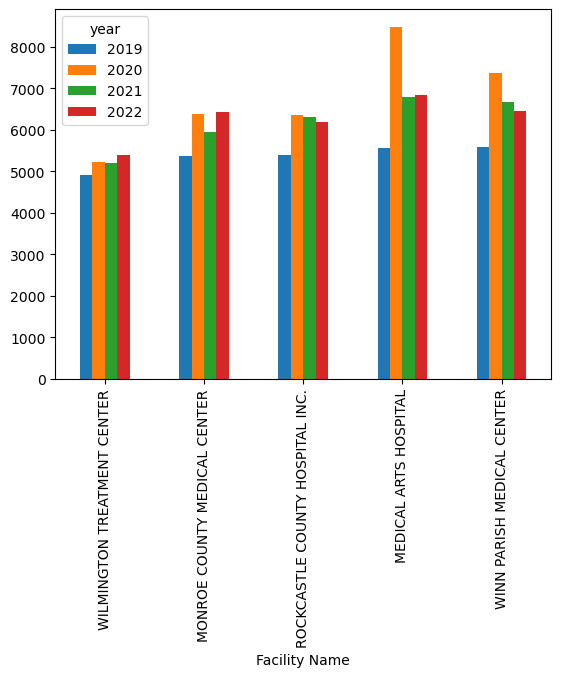

In [14]:
inpatient_no_totals_year.dropna().iloc[:5].plot(kind='bar')

In [15]:
inpatient_no_totals_prior = all_data_no_total[(all_data_no_total['Period']=='1 to 3 days Prior to Index Hospital Admission') &(all_data_no_total['Claim Type']=='Inpatient')]#
inpatient_no_totals_year_prior = inpatient_no_totals_prior.pivot_table(index='Facility Name', columns='year', values='Avg Spndg Per EP Hospital').sort_values(2019)

<Axes: xlabel='Facility Name'>

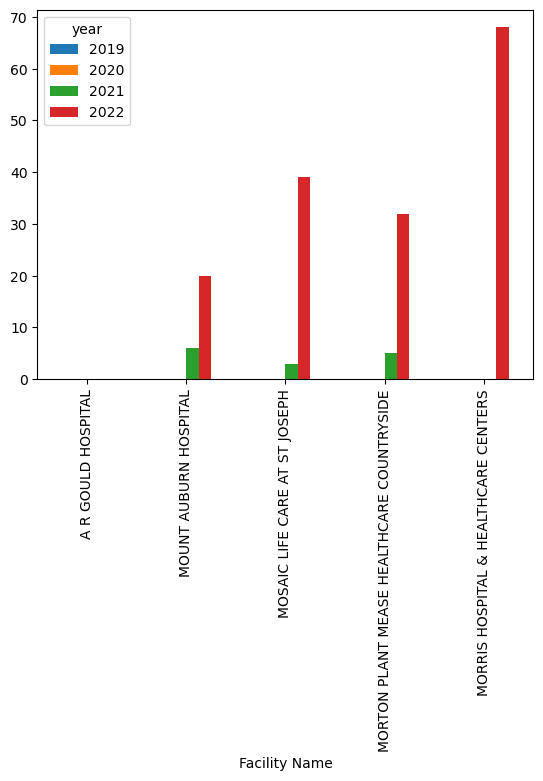

In [16]:
inpatient_no_totals_year_prior.dropna().iloc[:5].plot(kind='bar')

In [17]:
# Function to get top 5 hospitals for each group
def top5_hospitals(group):
    return group.nlargest(5, 'Avg Spndg Per EP Hospital')

yearly_agg = all_data_no_total.groupby(['Facility Name', 'State', 'year']).agg({'Avg Spndg Per EP Hospital': 'sum'}).reset_index()
# Use groupby on the grouped DataFrame, sort values within each group, and pick the top 5
top_hospital = yearly_agg.groupby(['State', 'year']).apply(top5_hospitals).reset_index(drop=True)
top_hospital

,Facility Name,State,year,Avg Spndg Per EP Hospital
0,PROVIDENCE ALASKA MEDICAL CENTER,AK,2019,22095
1,ALASKA REGIONAL HOSPITAL,AK,2019,21053
2,ALASKA NATIVE MEDICAL CENTER,AK,2019,19703
3,MAT-SU REGIONAL MEDICAL CENTER,AK,2019,18334
4,CENTRAL PENINSULA GENERAL HOSPITAL,AK,2019,17274
...,...,...,...,...
995,SUMMIT MEDICAL CENTER,WY,2022,30415
996,WYOMING MEDICAL CENTER,WY,2022,25790
997,CHEYENNE REGIONAL MEDICAL CENTER,WY,2022,22809
998,CAMPBELL COUNTY HEALTH,WY,2022,22474


In [18]:
# Step 1: Identify top 5 hospitals in 2019 across all states
top_hospitals_2019 = top_hospital[top_hospital['year'] == 2019]
top_hospitals_2019.head

<bound method NDFrame.head of                           Facility Name State  year  Avg Spndg Per EP Hospital
0      PROVIDENCE ALASKA MEDICAL CENTER    AK  2019                      22095
1              ALASKA REGIONAL HOSPITAL    AK  2019                      21053
2          ALASKA NATIVE MEDICAL CENTER    AK  2019                      19703
3        MAT-SU REGIONAL MEDICAL CENTER    AK  2019                      18334
4    CENTRAL PENINSULA GENERAL HOSPITAL    AK  2019                      17274
..                                  ...   ...   ...                        ...
980               SUMMIT MEDICAL CENTER    WY  2019                      25190
981              WYOMING MEDICAL CENTER    WY  2019                      22255
982    CHEYENNE REGIONAL MEDICAL CENTER    WY  2019                      20759
983              CAMPBELL COUNTY HEALTH    WY  2019                      20323
984          SHERIDAN MEMORIAL HOSPITAL    WY  2019                      17847

[250 rows x 4 columns

In [19]:
top_hospitals_2019[top_hospitals_2019['State'].isin(['NY', 'CA', 'VT', 'FL', 'WA', 'IL', 'TX', 'WY','LA','AL'])]

,Facility Name,State,year,Avg Spndg Per EP Hospital
20,UNIVERSITY OF ALABAMA HOSPITAL,AL,2019,26305
21,USA HEALTH UNIVERSITY HOSPITAL,AL,2019,24272
22,SOUTHEAST ALABAMA MEDICAL CENTER,AL,2019,23932
23,ST VINCENT'S BIRMINGHAM,AL,2019,23373
24,GRANDVIEW MEDICAL CENTER,AL,2019,23364
80,GOOD SAMARITAN HOSPITAL,CA,2019,72935
81,ST MARY MEDICAL CENTER,CA,2019,49279
82,ST JOSEPH HOSPITAL,CA,2019,48394
83,GLENDORA COMMUNITY HOSPITAL,CA,2019,33651
84,GREATER EL MONTE COMMUNITY HOSPITAL,CA,2019,32290


In [62]:
list_top_hosp_2019 = top_hospitals_2019[top_hospitals_2019['State'].isin(['NY', 'CA', 'VT', 'FL', 'WA', 'IL', 'TX', 'WY','LA','AL'])][["Facility Name", "State"]].values.tolist()

In [63]:
print(list_top_hosp_2019)

[['UNIVERSITY OF ALABAMA HOSPITAL', 'AL'], ['USA HEALTH UNIVERSITY HOSPITAL', 'AL'], ['SOUTHEAST ALABAMA MEDICAL CENTER', 'AL'], ["ST VINCENT'S BIRMINGHAM", 'AL'], ['GRANDVIEW MEDICAL CENTER', 'AL'], ['GOOD SAMARITAN HOSPITAL', 'CA'], ['ST MARY MEDICAL CENTER', 'CA'], ['ST JOSEPH HOSPITAL', 'CA'], ['GLENDORA COMMUNITY HOSPITAL', 'CA'], ['GREATER EL MONTE COMMUNITY HOSPITAL', 'CA'], ['JACKSON HEALTH SYSTEM', 'FL'], ['LARKIN COMMUNITY HOSPITAL PALM SPRINGS CAMPUS', 'FL'], ['BROWARD HEALTH MEDICAL CENTER', 'FL'], ['LAWNWOOD REGIONAL MEDICAL CENTER & HEART INSTITUTE', 'FL'], ['MEMORIAL REGIONAL HOSPITAL', 'FL'], ['AMITA HEALTH RESURRECTION MEDICAL CENTER', 'IL'], ['MIDWESTERN REGION MED CENTER', 'IL'], ['LOUIS A WEISS MEMORIAL HOSPITAL', 'IL'], ['ADVOCATE CHRIST HOSPITAL & MEDICAL CENTER', 'IL'], ['ALEXIAN BROTHERS MEDICAL CENTER 1', 'IL'], ['THE SPINE HOSPITAL OF LOUISIANA', 'LA'], ['STERLING SURGICAL HOSPITAL', 'LA'], ['CYPRESS POINTE SURGICAL HOSPITAL', 'LA'], ['SPECIALISTS HOSPITAL SHR

In [64]:
top_hosps_years = inpatient_no_totals_year[inpatient_no_totals_year.index.isin(list_top_hosp_2019)]
top_hosps_years.dropna()

year,2019,2020,2021,2022
Facility Name,,,,


In [23]:
#FILTERING DATA TO ONLY INCLUDE TOP 5 HOSPITALS FROM 2019 AS TOP HOSPITALS FROM ALL YEARS
top_hospitals_allyears = top_hospital[top_hospital['Facility Name'].isin(top_hospitals_2019['Facility Name'])]
top5_hospitals_allyears = top_hospitals_allyears.groupby(['State', 'year']).apply(top5_hospitals).reset_index(drop=True)
top5_hospitals_allyears.head()

,Facility Name,State,year,Avg Spndg Per EP Hospital
0,PROVIDENCE ALASKA MEDICAL CENTER,AK,2019,22095
1,ALASKA REGIONAL HOSPITAL,AK,2019,21053
2,ALASKA NATIVE MEDICAL CENTER,AK,2019,19703
3,MAT-SU REGIONAL MEDICAL CENTER,AK,2019,18334
4,CENTRAL PENINSULA GENERAL HOSPITAL,AK,2019,17274


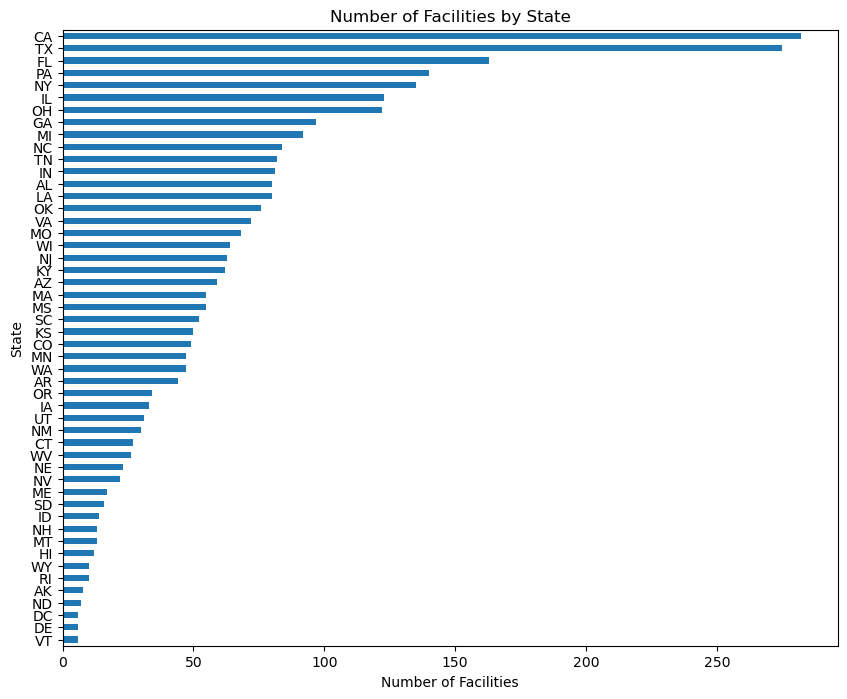

In [33]:
#move to the top.
df2019 = get_yearly_data_with_total(2019)
# Assuming df is your DataFrame containing the data
# Group data by State and count the number of unique facilities
facility_counts_by_state = df2019.groupby('State')['Facility ID'].nunique().sort_values()
# Plot horizontal bar chart to visualize proportion of facilities by state
plt.figure(figsize=(10, 8))
facility_counts_by_state.plot(kind='barh')
plt.xlabel('Number of Facilities')
plt.ylabel('State')
plt.title('Number of Facilities by State')
plt.show()